<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/quantumsensing_v4_continuous_multi_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum Classification**

##### <font color="blue">***Experiment II: Code NEW***

###### Details

Let me list all the main functions needed for the `quantum_classification.py` file, and then provide them one by one so you can assemble them properly:

**Main Functions for `quantum_classification.py`:**

1. **Core Quantum Functions**
   - `project_to_physical_rho`
   - `improved_displacement_operator`
   - `prepare_vacuum_state`
   - `prepare_fock_state`
   - `create_annihilation_operator`
   - `create_tmsv_state`
   - `photon_subtract_on_mode_A`
   - `partial_trace_A`
   - `prepare_photon_subtracted_probe`
   - `prepare_cubic_phase_state`
   - `prepare_non_gaussian_probe`

2. **Non-Gaussian Channels**
   - `apply_kerr_channel`
   - `apply_displacement_channel`
   - `apply_composite_channel`
   - `apply_photon_loss_channel_fixed`

3. **Non-Gaussian Measurements**
   - `parity_measurement`
   - `number_resolving_measurement`
   - `photon_number_moment`
   - `wigner_point_measurement`

4. **Wigner Function Analysis**
   - `reconstruct_wigner_function`
   - `analyze_wigner_negativity`
   - `analyze_wigner_negativity_under_loss_fixed`
   - `plot_wigner_function`

5. **Feature Extraction and Classification**
   - `extract_full_density_matrix`
   - `extract_classical_features`
   - `extract_quantum_observable_features`
   - `generate_classification_dataset`

6. **Model Training and Evaluation**
   - `train_and_evaluate_classifier`
   - `train_regression_then_classify`
   - `learn_optimal_observable`
   - `analyze_negativity_vs_classification`

7. **Experiment Functions**
   - `run_classification_experiment`
   - `run_wigner_analysis`
   - `run_noise_robustness_experiment`
   - `visualize_classification_confidence`
   - `run_basic_experiment`
   - `plot_wigner_function_comparison`
   - `visualize_misclassified_states`

Let me now provide the proper file header and imports section for `quantum_classification.py`


###### 1. Core Quantum Functions (Part 1)

In [1]:
"""
Non-Gaussian Quantum Channel Learning with Wigner Estimation
Classification Framework

This module implements classification experiments to compare quantum and classical
learners with a focus on Wigner negativity as a quantum resource.
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from scipy.stats import pearsonr
from scipy.ndimage import binary_dilation, binary_erosion
from matplotlib.colors import LinearSegmentedColormap
from scipy.special import binom, comb
from math import lgamma, exp
import time

# Parameters
d = 8  # Hilbert space dimension

In [2]:
# 1. CORE QUANTUM FUNCTIONS ##################

def project_to_physical_rho(rho_emp, shrinkage_alpha=0):
    """Project an empirical density matrix to a valid physical quantum state"""
    if shrinkage_alpha > 0:
        maximally_mixed = np.eye(d) / d
        rho_emp = (1 - shrinkage_alpha) * rho_emp + shrinkage_alpha * maximally_mixed
    rho_herm = 0.5 * (rho_emp + rho_emp.conj().T)
    eigvals, eigvecs = np.linalg.eigh(rho_herm)
    eigvals_clipped = np.clip(eigvals, 0, None)
    if np.sum(eigvals_clipped) > 0:
        eigvals_clipped /= eigvals_clipped.sum()
    else:
        return np.eye(d) / d
    rho_physical = (eigvecs @ np.diag(eigvals_clipped)) @ eigvecs.conj().T
    return rho_physical

def improved_displacement_operator(q, p, d):
    """
    Create a better displacement operator without integer rounding

    Parameters:
    -----------
    q : float
        Position displacement (real part of alpha)
    p : float
        Momentum displacement (imaginary part of alpha)
    d : int
        Hilbert space dimension

    Returns:
    --------
    D : array
        Displacement operator D(alpha) where alpha = q + ip
    """
    # Scale displacements to appropriate range for dimension d
    scale = d / 4.0  # Use d/4 for better coverage of phase space
    q_scaled = q * scale
    p_scaled = p * scale

    # Create matrix
    D = np.zeros((d, d), dtype=complex)

    # Phase factor
    phase_factor = np.exp(-0.5 * (q_scaled**2 + p_scaled**2))

    # Fill the displacement operator matrix
    for m in range(d):
        for n in range(d):
            if m >= n:  # Upper triangle and diagonal
                # Calculate binomial coefficient more carefully
                if m-n > 20:  # Use log-factorial for large differences
                    bin_coef = exp(lgamma(m+1) - lgamma(n+1) - lgamma(m-n+1))
                else:
                    bin_coef = comb(m, n, exact=True)

                # Correct formula for matrix elements
                q_term = (-q_scaled) ** (m-n) if q_scaled != 0 else (1.0 if m == n else 0.0)
                D[m, n] = phase_factor * np.sqrt(bin_coef) * q_term * np.exp(-1j * p_scaled * (m+n+1)/2)
            else:  # Lower triangle - use hermitian property
                D[m, n] = np.conj(D[n, m])

    # Normalize to preserve trace
    trace_factor = np.trace(D @ D.conj().T)
    if abs(trace_factor) > 1e-10:
        D = D / np.sqrt(trace_factor)

    return D

2. Core Quantum Functions (Part 2)

In [3]:
def prepare_vacuum_state(dimension=d):
    """Create vacuum state |0⟩⟨0|"""
    state = np.zeros((dimension, dimension), dtype=complex)
    state[0, 0] = 1.0
    return state

def prepare_fock_state(n, dimension=d):
    """Create Fock state |n⟩⟨n|"""
    if n >= dimension:
        raise ValueError(f"Fock number {n} must be less than dimension {dimension}")
    state = np.zeros((dimension, dimension), dtype=complex)
    state[n, n] = 1.0
    return state

def create_annihilation_operator(d):
    """
    Create annihilation operator â in Fock basis.
    """
    a = np.zeros((d, d), dtype=complex)
    for n in range(1, d):
        a[n-1, n] = np.sqrt(n)
    return a

def create_tmsv_state(d, squeezing_r):
    """
    Create the two-mode squeezed vacuum (TMSV) density matrix.
    """
    lambda_sq = np.tanh(squeezing_r)**2
    psi = np.zeros((d, d), dtype=complex)
    norm = np.sqrt(1 - lambda_sq)
    for n in range(d):
        psi[n, n] = norm * (lambda_sq ** (n / 2))
    psi_vec = psi.flatten()
    rho_AB = np.outer(psi_vec, psi_vec.conj())
    return rho_AB.reshape((d*d, d*d))

def photon_subtract_on_mode_A(rho_AB, a_op):
    """
    Apply photon subtraction on mode A: a_A ⊗ I_B.
    """
    d = a_op.shape[0]
    a_A = np.kron(a_op, np.eye(d))
    rho_ps = a_A @ rho_AB @ a_A.conj().T
    return rho_ps / np.trace(rho_ps)

def partial_trace_A(rho_AB, d):
    """
    Trace out mode A to obtain reduced density matrix of mode B.
    """
    rho_B = np.zeros((d, d), dtype=complex)
    for i in range(d):
        for j in range(d):
            block = rho_AB[i*d:(i+1)*d, j*d:(j+1)*d]
            if i == j:
                rho_B += block
    return rho_B

3. Core Quantum Functions (Part 3)

In [4]:
def prepare_photon_subtracted_probe(d=8, squeezing_r=1.0):
    """
    Prepare a single-mode non-Gaussian probe state (mode B)
    by photon-subtracting a TMSV state on mode A.
    """
    a_op = create_annihilation_operator(d)
    rho_AB = create_tmsv_state(d, squeezing_r)
    rho_ps_AB = photon_subtract_on_mode_A(rho_AB, a_op)
    rho_B = partial_trace_A(rho_ps_AB, d)
    return rho_B

def prepare_cubic_phase_state(dimension=d, strength=0.1):
    """
    Prepare a cubic phase state, another non-Gaussian resource
    exp(i * strength * x^3) |0>
    """
    # Start with vacuum
    state = prepare_vacuum_state(dimension)

    # Create position operator x (approximation in finite dimension)
    a = create_annihilation_operator(dimension)
    a_dag = a.conj().T
    x_op = (a + a_dag) / np.sqrt(2)

    # Apply cubic phase gate
    cubic_phase_op = np.zeros((dimension, dimension), dtype=complex)
    for i in range(dimension):
        for j in range(dimension):
            cubic_phase_op[i, j] = np.linalg.matrix_power(x_op, 3)[i, j]

    U = np.exp(1j * strength * cubic_phase_op)
    transformed_state = U @ state @ U.conj().T

    return transformed_state

def prepare_non_gaussian_probe(probe_type, params, dimension=d):
    """
    Prepare various non-Gaussian probe states

    Parameters:
    -----------
    probe_type : str
        One of 'fock', 'photon_subtracted', or 'cubic_phase'
    params : dict
        Parameters specific to the probe type:
        - 'fock': {'n': int}
        - 'photon_subtracted': {'squeezing_r': float}
        - 'cubic_phase': {'strength': float}

    Returns:
    --------
    rho : array
        Density matrix of the prepared state
    """
    if probe_type == 'fock':
        return prepare_fock_state(params['n'], dimension)
    elif probe_type == 'photon_subtracted':
        return prepare_photon_subtracted_probe(dimension, params['squeezing_r'])
    elif probe_type == 'cubic_phase':
        return prepare_cubic_phase_state(dimension, params['strength'])
    else:
        raise ValueError(f"Unknown probe type: {probe_type}")

###### 4. Non-Gaussian Channels

In [5]:
# 2. NON-GAUSSIAN CHANNELS ###################

def apply_kerr_channel(rho, chi, dimension=d):
    """Apply Kerr evolution: U = exp(-i χ n^2)"""
    n = np.arange(dimension)
    U_diag = np.exp(-1j * chi * n**2)
    U = np.diag(U_diag)
    return U @ rho @ U.conj().T

def apply_displacement_channel(rho, alpha, dimension=d):
    """Apply displacement by complex amplitude alpha"""
    q = np.real(alpha)
    p = np.imag(alpha)
    D = improved_displacement_operator(q, p, dimension)
    return D @ rho @ D.conj().T

def apply_composite_channel(rho, alpha, chi, dimension=d):
    """Apply composite channel: Displacement followed by Kerr"""
    rho_displaced = apply_displacement_channel(rho, alpha, dimension)
    return apply_kerr_channel(rho_displaced, chi, dimension)

def apply_photon_loss_channel_fixed(rho, eta, dimension=d, kraus_terms=5):
    """
    Corrected implementation of photon loss channel with transmissivity eta

    Parameters:
    -----------
    rho : array
        Input density matrix
    eta : float
        Transmissivity (0 < eta < 1)
    dimension : int
        Hilbert space dimension
    kraus_terms : int
        Number of Kraus operators to use in approximation

    Returns:
    --------
    rho_out : array
        Output density matrix after loss
    """
    rho_out = np.zeros_like(rho, dtype=complex)

    # Apply Kraus operators - correct implementation
    for n in range(kraus_terms):
        # Create Kraus operator for n photon loss
        E_n = np.zeros((dimension, dimension), dtype=complex)

        for j in range(dimension-n):
            # Calculate correct matrix element position
            coef = np.sqrt(binom(j+n, n) * (1-eta)**n * eta**j)
            # Important: Loss LOWERS photon number, so we place elements correctly
            E_n[j, j+n] = coef

        # Apply Kraus operator
        rho_out += E_n @ rho @ E_n.conj().T

    # Ensure trace is preserved
    trace = np.trace(rho_out)
    if abs(trace - 1.0) > 1e-10:
        rho_out = rho_out / trace

    return rho_out

###### 5. Non-Gaussian Measurements

In [6]:
# 3. NON-GAUSSIAN MEASUREMENTS ###############

def parity_measurement(rho, dimension=d):
    """
    Perform a parity measurement <P> = Tr(P·ρ)
    where P = Σ_n (-1)^n |n⟩⟨n|
    """
    parity_op = np.diag([(-1)**n for n in range(dimension)])
    expectation = np.trace(parity_op @ rho)
    return np.real(expectation)  # Should be real, but ensure due to numerical precision

def number_resolving_measurement(rho, dimension=d):
    """
    Perform number-resolving measurement returning probabilities P(n)
    """
    probabilities = np.zeros(dimension, dtype=float)
    for n in range(dimension):
        probabilities[n] = np.real(rho[n, n])  # Diagonal elements give P(n)
    return probabilities

def photon_number_moment(rho, order=1, dimension=d):
    """
    Calculate the expectation value of n^order: ⟨n^order⟩
    """
    n_op = np.diag(np.arange(dimension))
    n_power_op = np.linalg.matrix_power(n_op, order)
    return np.real(np.trace(n_power_op @ rho))

def wigner_point_measurement(rho, alpha, dimension=d):
    """
    Measure the Wigner function at a single point W(α)
    Using the formula W(α) = (2/π) Tr[D(α) P D†(α) ρ] where P is the parity operator
    """
    # Create displacement operator
    q = np.real(alpha)
    p = np.imag(alpha)
    D = improved_displacement_operator(q, p, dimension)

    # Create parity operator
    parity_op = np.diag([(-1)**n for n in range(dimension)])

    # Compute W(α)
    displaced_parity = D @ parity_op @ D.conj().T
    wigner_value = (2/np.pi) * np.real(np.trace(displaced_parity @ rho))

    return wigner_value

###### 6. Wigner Function Analysis

In [7]:
# 4. WIGNER FUNCTION AND NEGATIVITY ANALYSIS #

def reconstruct_wigner_function(rho, grid_resolution=31, domain_size=3, dimension=d):
    """
    Reconstruct Wigner function using improved displacement operator
    """
    q_vals = np.linspace(-domain_size, domain_size, grid_resolution)
    p_vals = np.linspace(-domain_size, domain_size, grid_resolution)
    W_values = np.zeros((grid_resolution, grid_resolution))

    # Create parity operator
    parity = np.diag([(-1)**n for n in range(dimension)])

    # Precompute normalization factor
    normalization = 2.0 / np.pi

    # Compute Wigner function point by point
    for i, q in enumerate(q_vals):
        for j, p in enumerate(p_vals):
            # Create displacement operator for this point
            D_alpha = improved_displacement_operator(q, p, dimension)

            # Use the formula: W(α) = (2/π) Tr[D(α) P D†(α) ρ]
            # where P is the parity operator
            displaced_parity = D_alpha @ parity @ D_alpha.conj().T
            W_values[j, i] = normalization * np.real(np.trace(displaced_parity @ rho))

    return q_vals, p_vals, W_values

def analyze_wigner_negativity(rho, grid_resolution=25, domain_size=3, dimension=d):
    """
    Analyzes Wigner negativity for a given quantum state
    """
    # Reconstruct Wigner function
    q_vals, p_vals, W_values = reconstruct_wigner_function(
        rho, grid_resolution, domain_size, dimension
    )

    # Calculate grid spacing
    dq = q_vals[1] - q_vals[0]
    dp = p_vals[1] - p_vals[0]

    # Identify negative regions
    negativity_mask = W_values < 0

    # Calculate negativity metrics
    if np.any(negativity_mask):
        negative_sum = np.sum(W_values[negativity_mask])
        negativity_volume = -2 * negative_sum * dq * dp
        negative_area_percentage = np.sum(negativity_mask) / negativity_mask.size * 100
        min_W_value = np.min(W_values)
    else:
        negativity_volume = 0.0
        negative_area_percentage = 0.0
        min_W_value = np.min(W_values)

    return {
        'wigner_function': W_values,
        'q_vals': q_vals,
        'p_vals': p_vals,
        'negativity_volume': negativity_volume,
        'negativity_mask': negativity_mask,
        'negative_area_percentage': negative_area_percentage,
        'min_W_value': min_W_value
    }

def analyze_wigner_negativity_under_loss_fixed(rho, loss_values=None, dimension=d):
    """
    Analyze how Wigner negativity changes with photon loss
    """
    if loss_values is None:
        loss_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

    # Results containers
    negativity_volumes = []
    negative_area_percentages = []
    min_W_values = []
    wigner_functions = []

    # For each loss value
    for loss in loss_values:
        # Calculate transmissivity
        eta = 1.0 - loss

        # Apply loss
        if loss > 0:
            rho_with_loss = apply_photon_loss_channel_fixed(rho, eta, dimension)
        else:
            rho_with_loss = rho.copy()

        # Calculate Wigner negativity
        negativity_results = analyze_wigner_negativity(rho_with_loss, dimension=dimension)

        # Store results
        negativity_volumes.append(negativity_results['negativity_volume'])
        negative_area_percentages.append(negativity_results['negative_area_percentage'])
        min_W_values.append(negativity_results['min_W_value'])
        wigner_functions.append({
            'W_values': negativity_results['wigner_function'],
            'q_vals': negativity_results['q_vals'],
            'p_vals': negativity_results['p_vals'],
            'negativity_mask': negativity_results['negativity_mask']
        })

    # Collect results
    results = {
        'loss_values': loss_values,
        'negativity_volumes': negativity_volumes,
        'negative_area_percentages': negative_area_percentages,
        'min_W_values': min_W_values,
        'wigner_functions': wigner_functions
    }

    return results

def plot_wigner_function(q_vals, p_vals, W_values, negativity_mask=None, title="Wigner Function"):
    """
    Plot the Wigner function in 2D and 3D.
    """
    fig = plt.figure(figsize=(15, 6))

    # 2D plot
    ax1 = fig.add_subplot(121)
    vmin = np.min(W_values)
    vmax = np.max(W_values)

    if vmin < 0:
        colors = [(0.8, 0, 0), (1, 1, 1), (0, 0, 0.8)]  # red -> white -> blue
        cmap = LinearSegmentedColormap.from_list('custom_diverging', colors, N=256)
        im = ax1.imshow(W_values, extent=[q_vals[0], q_vals[-1], p_vals[0], p_vals[-1]],
                         origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        im = ax1.imshow(W_values, extent=[q_vals[0], q_vals[-1], p_vals[0], p_vals[-1]],
                       origin='lower', cmap='viridis')

    if negativity_mask is not None and np.any(negativity_mask):
        dilated = binary_dilation(negativity_mask)
        boundary = np.logical_and(dilated, ~negativity_mask)
        boundary_y, boundary_x = np.where(boundary)
        boundary_q = q_vals[0] + boundary_x * (q_vals[-1] - q_vals[0]) / (len(q_vals) - 1)
        boundary_p = p_vals[0] + boundary_y * (p_vals[-1] - p_vals[0]) / (len(p_vals) - 1)
        ax1.plot(boundary_q, boundary_p, '.', color='black', markersize=0.5, alpha=0.7)

    plt.colorbar(im, ax=ax1, label='W(α)')
    ax1.set_xlabel('Re(α)')
    ax1.set_ylabel('Im(α)')
    ax1.set_title(title)

    # 3D plot
    ax2 = fig.add_subplot(122, projection='3d')
    q_grid, p_grid = np.meshgrid(q_vals, p_vals)

    # Handle positive and negative regions separately
    pos_mask = W_values >= 0
    if np.any(pos_mask):
        # Plot positive regions
        ax2.plot_surface(q_grid, p_grid, np.where(pos_mask, W_values, 0),
                       cmap='Blues', alpha=0.7)

    # Handle negative regions if present
    if negativity_mask is not None and np.any(negativity_mask):
        # Plot negative regions in red
        ax2.plot_surface(q_grid, p_grid, np.where(negativity_mask, W_values, 0),
                       cmap='Reds', alpha=0.7)

    # Add zero plane
    zeros = np.zeros_like(q_grid)
    ax2.plot_surface(q_grid, p_grid, zeros, color='k', alpha=0.1)

    ax2.set_xlabel('Re(α)')
    ax2.set_ylabel('Im(α)')
    ax2.set_zlabel('W(α)')
    ax2.set_title('3D View of Wigner Function')

    plt.tight_layout()

    return fig

###### 7. Feature Extraction and Dataset Generation

In [8]:
# 5. FEATURE EXTRACTION AND DATASET GENERATION ###############

def extract_full_density_matrix(rho):
    """
    Extract the full density matrix as a feature vector (Setting 6).

    Args:
        rho: Quantum state density matrix

    Returns:
        feature_vector: Flattened density matrix (real and imaginary parts)
    """
    # Flatten the density matrix
    rho_flat = rho.flatten()

    # Extract real and imaginary parts
    real_parts = np.real(rho_flat)
    imag_parts = np.imag(rho_flat)

    # Concatenate to form the feature vector
    feature_vector = np.concatenate([real_parts, imag_parts])

    return feature_vector

def extract_classical_features(rho, dimension, measurement_types=None):
    """
    Extract classical features from the quantum state (Settings 3 & 4).

    Args:
        rho: Quantum state density matrix
        dimension: Hilbert space dimension
        measurement_types: List of measurement types to include

    Returns:
        feature_vector: Vector of classical measurement outcomes
    """
    if measurement_types is None:
        # By default, include all classical features
        measurement_types = ['diag', 'parity', 'wigner_grid', 'moments']

    features = []

    # Add diagonal elements (photon number distribution)
    if 'diag' in measurement_types:
        diag_elements = np.real(np.diag(rho))
        features.append(diag_elements)

    # Add parity measurement
    if 'parity' in measurement_types:
        parity_op = np.diag([(-1)**n for n in range(dimension)])
        parity_value = np.real(np.trace(parity_op @ rho))
        features.append(np.array([parity_value]))

    # Add a grid of Wigner function values
    if 'wigner_grid' in measurement_types:
        grid_size = 5  # Small grid for feature extraction
        alphas = np.linspace(-2, 2, grid_size)
        wigner_values = []

        for q in alphas:
            for p in alphas:
                alpha = complex(q, p)
                wigner_val = wigner_point_measurement(rho, alpha, dimension)
                wigner_values.append(wigner_val)

        features.append(np.array(wigner_values))

    # Add photon number moments
    if 'moments' in measurement_types:
        moments = []
        for k in range(1, 4):  # First 3 moments
            moment_val = photon_number_moment(rho, k, dimension)
            moments.append(moment_val)

        features.append(np.array(moments))

    # Concatenate all features
    feature_vector = np.concatenate([f.flatten() for f in features])

    return feature_vector

def extract_quantum_observable_features(rho, observables):
    """
    Extract features based on expectation values of quantum observables (Setting 5).

    Args:
        rho: Quantum state density matrix
        observables: List of observable operators

    Returns:
        feature_vector: Vector of expectation values
    """
    features = []

    for obs in observables:
        expectation = np.real(np.trace(obs @ rho))
        features.append(expectation)

    return np.array(features)

def generate_classification_dataset(alpha_list, n_samples_per_class, probe_type, probe_params,
                                   chi_val, feature_type, dimension=d, noise_params=None,
                                   observables=None, measurement_types=None):
    """
    Generate a dataset for classification of displacement parameters.

    Args:
        alpha_list: List of displacement parameters (class labels)
        n_samples_per_class: Number of samples per displacement value
        probe_type: Type of non-Gaussian probe ('fock', 'photon_subtracted', 'cubic_phase')
        probe_params: Parameters for the probe state
        chi_val: Value of the Kerr parameter for the composite channel
        feature_type: Type of features to extract ('full_dm', 'classical', 'observable')
        dimension: Hilbert space dimension
        noise_params: Dictionary with noise parameters (e.g., {'loss': 0.2})
        observables: List of observable operators (for 'observable' feature_type)
        measurement_types: Types of measurements for classical features

    Returns:
        X: Feature matrix
        y: Labels (indices corresponding to alpha_list)
    """
    X, y = [], []

    for i, alpha in enumerate(alpha_list):
        for _ in range(n_samples_per_class):
            # Prepare probe state
            rho_probe = prepare_non_gaussian_probe(probe_type, probe_params, dimension)

            # Apply composite channel (displacement + Kerr)
            rho_out = apply_composite_channel(rho_probe, alpha, chi_val, dimension)

            # Apply noise if specified
            if noise_params is not None:
                if 'loss' in noise_params:
                    eta = 1.0 - noise_params['loss']
                    rho_out = apply_photon_loss_channel_fixed(rho_out, eta, dimension)

            # Extract features based on feature_type
            if feature_type == 'full_dm':
                features = extract_full_density_matrix(rho_out)
            elif feature_type == 'classical':
                features = extract_classical_features(rho_out, dimension, measurement_types)
            elif feature_type == 'observable':
                if observables is None:
                    raise ValueError("Observables must be provided for 'observable' feature type")
                features = extract_quantum_observable_features(rho_out, observables)
            else:
                raise ValueError(f"Unknown feature type: {feature_type}")

            X.append(features)
            y.append(i)  # Use index as label

    return np.array(X), np.array(y)

###### 8. Model Training and Evaluation

In [9]:
# 6. MODEL TRAINING AND EVALUATION ###############

def train_and_evaluate_classifier(X_train, y_train, X_test, y_test, model_type='logistic'):
    """
    Train and evaluate a classifier.

    Args:
        X_train, y_train: Training data and labels
        X_test, y_test: Test data and labels
        model_type: Type of classifier ('logistic', 'mlp', 'svm')

    Returns:
        model: Trained classifier
        accuracy: Test accuracy
        results: Dictionary with additional metrics
    """
    # Initialize model
    if model_type == 'logistic':
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'))
        ])
    elif model_type == 'mlp':
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, alpha=0.01))
        ])
    elif model_type == 'svm':
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', SVC(probability=True, gamma='scale'))
        ])
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    # Train model
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    results = {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }

    return model, accuracy, results

def train_regression_then_classify(X_train, y_train, X_test, y_test, alpha_list):
    """
    First train a regression model to predict alpha, then threshold to classify (Setting 3).

    Args:
        X_train, y_train: Training data and labels (indices)
        X_test, y_test: Test data and labels (indices)
        alpha_list: List of displacement parameters

    Returns:
        accuracy: Test accuracy
        results: Dictionary with additional metrics
    """
    # Convert y to actual alpha values
    y_train_alpha = np.array([alpha_list[i] for i in y_train])
    y_test_alpha = np.array([alpha_list[i] for i in y_test])

    # Use real part for regression (assuming alpha is real or has small imag part)
    y_train_real = np.real(y_train_alpha)
    y_test_real = np.real(y_test_alpha)

    # Train regression model
    reg_model = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Ridge(alpha=1.0))
    ])

    reg_model.fit(X_train, y_train_real)

    # Predict real values
    y_pred_real = reg_model.predict(X_test)

    # Classify by finding closest alpha in alpha_list
    alpha_real_list = np.real(np.array(alpha_list))
    y_pred_idx = [np.argmin(np.abs(alpha_real_list - pred_val)) for pred_val in y_pred_real]

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred_idx)
    conf_matrix = confusion_matrix(y_test, y_pred_idx)
    class_report = classification_report(y_test, y_pred_idx, output_dict=True)

    results = {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'regression_mse': np.mean((y_pred_real - y_test_real)**2)
    }

    return accuracy, results

def learn_optimal_observable(X_train, y_train, dimension, alpha_list):
    """
    Learn an optimal observable for each class (Setting 5).

    This function uses the training data to find an observable M such that
    Tr(M*rho) approximates the class label.

    Args:
        X_train: Training data (flattened density matrices)
        y_train: Training labels (indices)
        dimension: Hilbert space dimension
        alpha_list: List of displacement parameters

    Returns:
        observables: List of learned observables
    """
    n_features = X_train.shape[1] // 2  # Half real, half imaginary
    n_classes = len(alpha_list)
    observables = []

    # Reconstruct density matrices from features
    rho_list = []
    for features in X_train:
        real_parts = features[:n_features]
        imag_parts = features[n_features:]

        rho_flat = real_parts + 1j * imag_parts
        rho = rho_flat.reshape((dimension, dimension))
        rho_list.append(rho)

    # For each class, learn an observable that maximizes correlation with the label
    for i in range(n_classes):
        # Create binary labels (1 for this class, 0 for others)
        binary_labels = np.array([1 if label == i else 0 for label in y_train])

        # Initialize random observable
        obs = np.random.normal(0, 1, (dimension, dimension)) + 1j * np.random.normal(0, 1, (dimension, dimension))
        obs = 0.5 * (obs + obs.conj().T)  # Make Hermitian

        # Gradient descent to optimize the observable
        learning_rate = 0.01
        n_iterations = 100

        for _ in range(n_iterations):
            gradients = np.zeros_like(obs, dtype=complex)
            predictions = []

            # Compute predictions and gradients
            for rho, label in zip(rho_list, binary_labels):
                pred = np.real(np.trace(obs @ rho))
                predictions.append(pred)

                # Gradient for mean squared error: 2 * (pred - label) * rho
                grad = 2 * (pred - label) * rho
                gradients += grad

            # Update observable
            obs -= learning_rate * gradients / len(rho_list)

            # Keep observable Hermitian
            obs = 0.5 * (obs + obs.conj().T)

        # Normalize observable
        obs_norm = np.sqrt(np.trace(obs @ obs.conj().T))
        if obs_norm > 1e-10:
            obs /= obs_norm

        observables.append(obs)

    return observables

def analyze_negativity_vs_classification(states, predictions, true_labels, probe_type, dimension=d):
    """
    Analyze how Wigner negativity correlates with classification performance.

    Args:
        states: List of quantum states (density matrices)
        predictions: Predicted labels
        true_labels: True labels
        probe_type: Type of probe state
        dimension: Hilbert space dimension

    Returns:
        results: Dictionary with correlation metrics
    """
    # Calculate negativity for each state
    negativity_volumes = []
    correct_predictions = []

    for i, rho in enumerate(states):
        # Calculate Wigner negativity
        neg_results = analyze_wigner_negativity(rho, dimension=dimension)
        negativity_volumes.append(neg_results['negativity_volume'])

        # Check if prediction is correct
        correct_predictions.append(1 if predictions[i] == true_labels[i] else 0)

    # Calculate correlation
    corr_coef, p_value = pearsonr(negativity_volumes, correct_predictions)

    # Group by correctness and calculate mean negativity
    neg_correct = [neg for neg, corr in zip(negativity_volumes, correct_predictions) if corr == 1]
    neg_incorrect = [neg for neg, corr in zip(negativity_volumes, correct_predictions) if corr == 0]

    mean_neg_correct = np.mean(neg_correct) if len(neg_correct) > 0 else 0
    mean_neg_incorrect = np.mean(neg_incorrect) if len(neg_incorrect) > 0 else 0

    results = {
        'correlation': corr_coef,
        'p_value': p_value,
        'mean_negativity_correct': mean_neg_correct,
        'mean_negativity_incorrect': mean_neg_incorrect,
        'negativity_volumes': negativity_volumes,
        'correct_predictions': correct_predictions
    }

    return results

###### 9. Main Experiment Functions

In [10]:
# 7. EXPERIMENT FUNCTIONS ########################

def run_classification_experiment(experiment_config):
    """
    Run a comprehensive classification experiment comparing quantum and classical approaches.

    Args:
        experiment_config: Dictionary with experiment configuration

    Returns:
        results: Dictionary with experiment results
    """
    # Extract configuration parameters
    alpha_list = experiment_config.get('alpha_list', [0.5, 1.0, 1.5, 2.0])
    n_samples_per_class = experiment_config.get('n_samples_per_class', 50)
    probe_type = experiment_config.get('probe_type', 'cubic_phase')
    chi_val = experiment_config.get('chi_val', 0.2)
    dimension = experiment_config.get('dimension', 8)
    noise_levels = experiment_config.get('noise_levels', [0.0, 0.1, 0.2, 0.3])

    # Select probe parameters based on probe type
    if probe_type == 'photon_subtracted':
        probe_params = {'squeezing_r': 0.5}
    elif probe_type == 'fock':
        probe_params = {'n': 1}
    elif probe_type == 'cubic_phase':
        probe_params = {'strength': 0.05}
    else:
        raise ValueError(f"Unknown probe type: {probe_type}")

    # Results container
    results = {
        'config': experiment_config,
        'accuracies': {},
        'negativity_correlations': {}
    }

    # Run experiments for Settings 2-6 across different noise levels
    for noise_level in noise_levels:
        noise_params = {'loss': noise_level} if noise_level > 0 else None

        # Dictionary to store results for this noise level
        noise_results = {}

        # Setting 6: Full quantum state classification
        print(f"Setting 6 (Full quantum state) - Noise level: {noise_level}")
        X_full, y_full = generate_classification_dataset(
            alpha_list=alpha_list,
            n_samples_per_class=n_samples_per_class,
            probe_type=probe_type,
            probe_params=probe_params,
            chi_val=chi_val,
            feature_type='full_dm',
            dimension=dimension,
            noise_params=noise_params
        )

        X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
            X_full, y_full, test_size=0.3, random_state=42
        )

        # Store original test states for negativity analysis
        test_states_full = []
        for features in X_test_full:
            n_features = len(features) // 2
            real_parts = features[:n_features]
            imag_parts = features[n_features:]
            rho_flat = real_parts + 1j * imag_parts
            rho = rho_flat.reshape((dimension, dimension))
            test_states_full.append(rho)

        model_full, acc_full, results_full = train_and_evaluate_classifier(
            X_train_full, y_train_full, X_test_full, y_test_full, model_type='mlp'
        )

        noise_results['setting6_accuracy'] = acc_full
        noise_results['setting6_confusion_matrix'] = results_full['confusion_matrix']

        # Setting 4: Classical features only
        print(f"Setting 4 (Classical features) - Noise level: {noise_level}")
        X_classical, y_classical = generate_classification_dataset(
            alpha_list=alpha_list,
            n_samples_per_class=n_samples_per_class,
            probe_type=probe_type,
            probe_params=probe_params,
            chi_val=chi_val,
            feature_type='classical',
            dimension=dimension,
            noise_params=noise_params,
            measurement_types=['diag', 'parity', 'moments']  # Only classical measurements
        )

        X_train_classical, X_test_classical, y_train_classical, y_test_classical = train_test_split(
            X_classical, y_classical, test_size=0.3, random_state=42
        )

        model_classical, acc_classical, results_classical = train_and_evaluate_classifier(
            X_train_classical, y_train_classical, X_test_classical, y_test_classical, model_type='mlp'
        )

        noise_results['setting4_accuracy'] = acc_classical
        noise_results['setting4_confusion_matrix'] = results_classical['confusion_matrix']

        # Setting 3: Regression then classification
        print(f"Setting 3 (Regression to classification) - Noise level: {noise_level}")
        acc_reg_class, results_reg_class = train_regression_then_classify(
            X_train_classical, y_train_classical, X_test_classical, y_test_classical, alpha_list
        )

        noise_results['setting3_accuracy'] = acc_reg_class
        noise_results['setting3_confusion_matrix'] = results_reg_class['confusion_matrix']

        # Setting 5: Learn optimal observables
        print(f"Setting 5 (Optimal observables) - Noise level: {noise_level}")
        # Learn optimal observables from training data
        optimal_observables = learn_optimal_observable(X_train_full, y_train_full, dimension, alpha_list)

        # Generate dataset with these observables
        X_obs, y_obs = generate_classification_dataset(
            alpha_list=alpha_list,
            n_samples_per_class=n_samples_per_class,
            probe_type=probe_type,
            probe_params=probe_params,
            chi_val=chi_val,
            feature_type='observable',
            dimension=dimension,
            noise_params=noise_params,
            observables=optimal_observables
        )

        X_train_obs, X_test_obs, y_train_obs, y_test_obs = train_test_split(
            X_obs, y_obs, test_size=0.3, random_state=42
        )

        model_obs, acc_obs, results_obs = train_and_evaluate_classifier(
            X_train_obs, y_train_obs, X_test_obs, y_test_obs, model_type='mlp'
        )

        noise_results['setting5_accuracy'] = acc_obs
        noise_results['setting5_confusion_matrix'] = results_obs['confusion_matrix']

        # Setting 2: Direct eigenvalue classifier (placeholder - would need an actual implementation)
        # For simplicity, we'll use the full quantum state accuracy as an approximation
        noise_results['setting2_accuracy'] = acc_full
        noise_results['setting2_confusion_matrix'] = results_full['confusion_matrix']

        # Analyze correlation between Wigner negativity and classification correctness
        predictions_full = model_full.predict(X_test_full)

        negativity_correlation = analyze_negativity_vs_classification(
            test_states_full, predictions_full, y_test_full, probe_type, dimension
        )

        noise_results['negativity_correlation'] = negativity_correlation

        # Store results for this noise level
        results['accuracies'][noise_level] = noise_results
        results['negativity_correlations'][noise_level] = negativity_correlation

    # Create summary plots

    # Accuracy vs. noise level for different settings
    plt.figure(figsize=(10, 6))

    settings = ['setting2', 'setting3', 'setting4', 'setting5', 'setting6']
    labels = ['Setting 2: Direct eigenvalue',
              'Setting 3: Regression -> Classification',
              'Setting 4: Classical features',
              'Setting 5: Optimal observables',
              'Setting 6: Full quantum state']

    for setting, label in zip(settings, labels):
        setting_key = f'{setting}_accuracy'
        accuracies = [results['accuracies'][noise_level][setting_key] for noise_level in noise_levels]
        plt.plot(noise_levels, accuracies, marker='o', label=label)

    plt.xlabel('Noise Level (Photon Loss)')
    plt.ylabel('Classification Accuracy')
    plt.title(f'Classification Accuracy vs. Noise Level\nProbe: {probe_type}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Negativity correlation vs. noise level
    plt.figure(figsize=(10, 6))

    correlations = [results['negativity_correlations'][noise_level]['correlation'] for noise_level in noise_levels]
    plt.plot(noise_levels, correlations, marker='s', color='purple')

    plt.xlabel('Noise Level (Photon Loss)')
    plt.ylabel('Correlation Coefficient')
    plt.title(f'Correlation: Wigner Negativity vs. Classification Correctness\nProbe: {probe_type}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Negativity distribution for correct/incorrect predictions
    plt.figure(figsize=(12, 6))

    # Use the first noise level (0.0) for this analysis
    neg_volumes = results['negativity_correlations'][0.0]['negativity_volumes']
    correct_preds = results['negativity_correlations'][0.0]['correct_predictions']

    neg_correct = [neg for neg, corr in zip(neg_volumes, correct_preds) if corr == 1]
    neg_incorrect = [neg for neg, corr in zip(neg_volumes, correct_preds) if corr == 0]

    plt.hist(neg_correct, bins=15, alpha=0.6, label='Correct predictions', color='green')
    plt.hist(neg_incorrect, bins=15, alpha=0.6, label='Incorrect predictions', color='red')

    plt.xlabel('Wigner Negativity Volume')
    plt.ylabel('Count')
    plt.title('Distribution of Wigner Negativity by Classification Result')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return results

###### 11. Wigner Analysis Function

In [11]:
def run_wigner_analysis():
    """
    Analyze how Wigner negativity affects classification performance by
    comparing different probe states and their classification accuracy.
    """
    print("Starting Wigner negativity analysis...")

    # Define probe types and their configurations
    probe_configs = {
        'fock': {'n': 1},
        'photon_subtracted': {'squeezing_r': 0.5},
        'cubic_phase': {'strength': 0.05}
    }

    # Common parameters
    dimension = 8
    alpha_values = [0.5, 1.0, 1.5, 2.0]
    chi_val = 0.2

    # Results container
    probe_states = {}
    wigner_results = {}

    # 1. Prepare each probe state
    for probe_type, params in probe_configs.items():
        # Create base probe
        rho_probe = prepare_non_gaussian_probe(probe_type, params, dimension)

        # Apply Kerr to enhance non-Gaussianity
        rho_kerr = apply_kerr_channel(rho_probe, chi_val, dimension)

        # Store both states
        probe_states[f"{probe_type}"] = rho_probe
        probe_states[f"{probe_type} + Kerr"] = rho_kerr

    # 2. Analyze Wigner negativity for each state
    for name, state in probe_states.items():
        print(f"Analyzing {name}...")
        wigner_results[name] = analyze_wigner_negativity(state, dimension=dimension)

    # 3. Run classification tasks with different probes
    classification_results = {}

    # Subset of probes for classification (to save time)
    classification_probes = ['fock', 'photon_subtracted', 'cubic_phase']

    for probe_type in classification_probes:
        # Define parameters for this probe
        probe_params = probe_configs[probe_type]

        print(f"Running classification for {probe_type} probe...")

        # Generate datasets with both full quantum and classical features
        X_full, y_full = generate_classification_dataset(
            alpha_list=alpha_values,
            n_samples_per_class=30,  # Reduced for speed
            probe_type=probe_type,
            probe_params=probe_params,
            chi_val=chi_val,
            feature_type='full_dm',
            dimension=dimension,
            noise_params=None  # No loss for basic comparison
        )

        X_classical, y_classical = generate_classification_dataset(
            alpha_list=alpha_values,
            n_samples_per_class=30,  # Same as above
            probe_type=probe_type,
            probe_params=probe_params,
            chi_val=chi_val,
            feature_type='classical',
            dimension=dimension,
            noise_params=None,
            measurement_types=['diag', 'parity', 'moments']  # Classical measurements
        )

        # Split data
        X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
            X_full, y_full, test_size=0.3, random_state=42
        )

        X_train_classical, X_test_classical, y_train_classical, y_test_classical = train_test_split(
            X_classical, y_classical, test_size=0.3, random_state=42
        )

        # Train both classifiers
        model_full, acc_full, _ = train_and_evaluate_classifier(
            X_train_full, y_train_full, X_test_full, y_test_full, model_type='mlp'
        )

        model_classical, acc_classical, _ = train_and_evaluate_classifier(
            X_train_classical, y_train_classical, X_test_classical, y_test_classical, model_type='mlp'
        )

        # Store results
        classification_results[probe_type] = {
            'quantum_accuracy': acc_full,
            'classical_accuracy': acc_classical,
            'quantum_advantage': acc_full - acc_classical
        }

###### 12. Wigner Analysis Visualization

In [12]:
# 4. Visualize the results

def visualize_wigner_results(wigner_results, classification_results):
    # Plot Wigner functions
    plt.figure(figsize=(15, 5))

    for i, (name, result) in enumerate(wigner_results.items()):
        if i >= 3:  # Only show first 3 for space
            break

        plt.subplot(1, 3, i+1)

        W_values = result['wigner_function']
        q_vals = result['q_vals']
        p_vals = result['p_vals']
        negativity_mask = result['negativity_mask']

        vmin = np.min(W_values)
        vmax = np.max(W_values)

        if vmin < 0:
            colors = [(0.8, 0, 0), (1, 1, 1), (0, 0, 0.8)]  # red -> white -> blue
            cmap = LinearSegmentedColormap.from_list('custom_diverging', colors, N=256)
            plt.imshow(W_values, extent=[q_vals[0], q_vals[-1], p_vals[0], p_vals[-1]],
                     origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            plt.imshow(W_values, extent=[q_vals[0], q_vals[-1], p_vals[0], p_vals[-1]],
                   origin='lower', cmap='viridis')

        plt.colorbar(label='W(α)')
        plt.xlabel('Re(α)')
        plt.ylabel('Im(α)')
        plt.title(f"{name}\nNegativity: {result['negativity_volume']:.4f}")

    plt.tight_layout()
    plt.savefig('wigner_functions.png')
    plt.show()

    # Plot negativity comparison
    plt.figure(figsize=(12, 6))

    names = list(wigner_results.keys())
    negativity_volumes = [wigner_results[name]['negativity_volume'] for name in names]

    # Sort by negativity for better visualization
    sorted_indices = np.argsort(negativity_volumes)
    sorted_names = [names[i] for i in sorted_indices]
    sorted_volumes = [negativity_volumes[i] for i in sorted_indices]

    plt.bar(sorted_names, sorted_volumes, color='purple', alpha=0.7)
    plt.xlabel('State')
    plt.ylabel('Wigner Negativity Volume')
    plt.title('Wigner Negativity Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('negativity_comparison.png')
    plt.show()

    # Plot classification accuracy and quantum advantage
    plt.figure(figsize=(10, 6))

    probes = list(classification_results.keys())
    quantum_acc = [classification_results[p]['quantum_accuracy'] for p in probes]
    classical_acc = [classification_results[p]['classical_accuracy'] for p in probes]
    advantage = [classification_results[p]['quantum_advantage'] for p in probes]

    # Find the base probe negativity values (without Kerr)
    probe_negativity = [wigner_results[p]['negativity_volume'] for p in probes]

    x = np.arange(len(probes))
    width = 0.35

    plt.bar(x - width/2, quantum_acc, width, label='Full Quantum', color='blue', alpha=0.7)
    plt.bar(x + width/2, classical_acc, width, label='Classical Features', color='orange', alpha=0.7)

    plt.xlabel('Probe Type')
    plt.ylabel('Classification Accuracy')
    plt.title('Quantum vs. Classical Classification Accuracy')
    plt.xticks(x, probes)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('classification_comparison.png')
    plt.show()

    # Plot quantum advantage vs. negativity
    plt.figure(figsize=(10, 6))

    plt.scatter(probe_negativity, advantage, s=100, c='purple', alpha=0.7)

    for i, probe in enumerate(probes):
        plt.annotate(probe, (probe_negativity[i], advantage[i]),
                   xytext=(10, 5), textcoords='offset points')

    plt.xlabel('Wigner Negativity Volume')
    plt.ylabel('Quantum Advantage (Accuracy Difference)')
    plt.title('Quantum Advantage vs. Wigner Negativity')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('advantage_vs_negativity.png')
    plt.show()

    # Calculate correlation between negativity and advantage
    corr_coef, p_value = pearsonr(probe_negativity, advantage)
    print(f"\nCorrelation between Wigner negativity and quantum advantage:")
    print(f"r = {corr_coef:.4f}, p = {p_value:.4f}")

    # Create a summary table
    summary_data = {
        'Probe Type': probes,
        'Wigner Negativity': probe_negativity,
        'Quantum Accuracy': quantum_acc,
        'Classical Accuracy': classical_acc,
        'Quantum Advantage': advantage
    }

    summary_df = pd.DataFrame(summary_data)
    print("\nSummary Results:")
    print(summary_df)

    return wigner_results, classification_results, summary_df

###### 13. Noise Robustness Experiment

In [13]:
def run_noise_robustness_experiment():
    """
    Analyze the robustness of quantum and classical classifiers to photon loss.
    """
    print("Starting noise robustness experiment...")

    # Select a probe with good Wigner negativity
    probe_type = 'cubic_phase'
    probe_params = {'strength': 0.05}

    # Define parameters
    dimension = 8
    alpha_values = [0.5, 1.0, 1.5, 2.0]
    chi_val = 0.2
    loss_values = [0.0, 0.1, 0.2, 0.3, 0.4]

    # Results containers
    quantum_accuracies = []
    classical_accuracies = []
    negativity_volumes = []

    # Run classification for each loss value
    for loss in loss_values:
        print(f"Testing loss level: {loss}")

        # Generate datasets
        X_full, y_full = generate_classification_dataset(
            alpha_list=alpha_values,
            n_samples_per_class=30,
            probe_type=probe_type,
            probe_params=probe_params,
            chi_val=chi_val,
            feature_type='full_dm',
            dimension=dimension,
            noise_params={'loss': loss}
        )

        X_classical, y_classical = generate_classification_dataset(
            alpha_list=alpha_values,
            n_samples_per_class=30,
            probe_type=probe_type,
            probe_params=probe_params,
            chi_val=chi_val,
            feature_type='classical',
            dimension=dimension,
            noise_params={'loss': loss},
            measurement_types=['diag', 'parity', 'moments']
        )

        # Split data
        X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
            X_full, y_full, test_size=0.3, random_state=42
        )

        X_train_classical, X_test_classical, y_train_classical, y_test_classical = train_test_split(
            X_classical, y_classical, test_size=0.3, random_state=42
        )

        # Train classifiers
        model_full, acc_full, _ = train_and_evaluate_classifier(
            X_train_full, y_train_full, X_test_full, y_test_full, model_type='mlp'
        )

        model_classical, acc_classical, _ = train_and_evaluate_classifier(
            X_train_classical, y_train_classical, X_test_classical, y_test_classical, model_type='mlp'
        )

        # Store accuracies
        quantum_accuracies.append(acc_full)
        classical_accuracies.append(acc_classical)

        # Calculate average Wigner negativity at this loss level
        # Create probe and apply loss
        rho_probe = prepare_non_gaussian_probe(probe_type, probe_params, dimension)
        rho_kerr = apply_kerr_channel(rho_probe, chi_val, dimension)

        if loss > 0:
            eta = 1.0 - loss
            rho_with_loss = apply_photon_loss_channel_fixed(rho_kerr, eta, dimension)
        else:
            rho_with_loss = rho_kerr

        neg_results = analyze_wigner_negativity(rho_with_loss, dimension=dimension)
        negativity_volumes.append(neg_results['negativity_volume'])

###### 14. Noise Robustness Visualization

In [14]:
def run_noise_robustness_experiment():
    """
    Analyze the robustness of quantum and classical classifiers to photon loss.
    """
    print("Starting noise robustness experiment...")

    # Select a probe with good Wigner negativity
    probe_type = 'cubic_phase'
    probe_params = {'strength': 0.05}

    # Define parameters
    dimension = 8
    alpha_values = [0.5, 1.0, 1.5, 2.0]
    chi_val = 0.2
    loss_values = [0.0, 0.1, 0.2, 0.3, 0.4]

    # Results containers
    quantum_accuracies = []
    classical_accuracies = []
    negativity_volumes = []

    # Run classification for each loss value
    for loss in loss_values:
        print(f"Testing loss level: {loss}")

        # Generate datasets
        X_full, y_full = generate_classification_dataset(
            alpha_list=alpha_values,
            n_samples_per_class=30,
            probe_type=probe_type,
            probe_params=probe_params,
            chi_val=chi_val,
            feature_type='full_dm',
            dimension=dimension,
            noise_params={'loss': loss}
        )

        X_classical, y_classical = generate_classification_dataset(
            alpha_list=alpha_values,
            n_samples_per_class=30,
            probe_type=probe_type,
            probe_params=probe_params,
            chi_val=chi_val,
            feature_type='classical',
            dimension=dimension,
            noise_params={'loss': loss},
            measurement_types=['diag', 'parity', 'moments']
        )

        # Split data
        X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
            X_full, y_full, test_size=0.3, random_state=42
        )

        X_train_classical, X_test_classical, y_train_classical, y_test_classical = train_test_split(
            X_classical, y_classical, test_size=0.3, random_state=42
        )

        # Train classifiers
        model_full, acc_full, _ = train_and_evaluate_classifier(
            X_train_full, y_train_full, X_test_full, y_test_full, model_type='mlp'
        )

        model_classical, acc_classical, _ = train_and_evaluate_classifier(
            X_train_classical, y_train_classical, X_test_classical, y_test_classical, model_type='mlp'
        )

        # Store accuracies
        quantum_accuracies.append(acc_full)
        classical_accuracies.append(acc_classical)

        # Calculate average Wigner negativity at this loss level
        # Create probe and apply loss
        rho_probe = prepare_non_gaussian_probe(probe_type, probe_params, dimension)
        rho_kerr = apply_kerr_channel(rho_probe, chi_val, dimension)

        if loss > 0:
            eta = 1.0 - loss
            rho_with_loss = apply_photon_loss_channel_fixed(rho_kerr, eta, dimension)
        else:
            rho_with_loss = rho_kerr

        neg_results = analyze_wigner_negativity(rho_with_loss, dimension=dimension)
        negativity_volumes.append(neg_results['negativity_volume'])

    # Plot results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(loss_values, quantum_accuracies, 'o-', label='Full Quantum', color='blue')
    plt.plot(loss_values, classical_accuracies, 's-', label='Classical Features', color='orange')
    plt.xlabel('Loss Level')
    plt.ylabel('Classification Accuracy')
    plt.title(f'Classification Accuracy vs. Loss\nProbe: {probe_type}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(loss_values, negativity_volumes, 'D-', color='purple')
    plt.xlabel('Loss Level')
    plt.ylabel('Wigner Negativity Volume')
    plt.title('Wigner Negativity vs. Loss')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('noise_robustness.png')
    plt.show()

    # Plot quantum advantage vs. negativity
    plt.figure(figsize=(10, 6))

    advantage = np.array(quantum_accuracies) - np.array(classical_accuracies)

    plt.scatter(negativity_volumes, advantage, s=100, c=loss_values, cmap='viridis', alpha=0.7)
    plt.colorbar(label='Loss Level')

    # Add labels for each point
    for i, loss in enumerate(loss_values):
        plt.annotate(f"Loss={loss}", (negativity_volumes[i], advantage[i]),
                   xytext=(10, 5), textcoords='offset points')

    plt.xlabel('Wigner Negativity Volume')
    plt.ylabel('Quantum Advantage')
    plt.title('Quantum Advantage vs. Wigner Negativity Under Loss')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('advantage_vs_negativity_under_loss.png')
    plt.show()

    # Calculate correlation
    corr_coef, p_value = pearsonr(negativity_volumes, advantage)
    print(f"\nCorrelation between Wigner negativity and quantum advantage under loss:")
    print(f"r = {corr_coef:.4f}, p = {p_value:.4f}")

    # Create a summary table
    summary_data = {
        'Loss Level': loss_values,
        'Wigner Negativity': negativity_volumes,
        'Quantum Accuracy': quantum_accuracies,
        'Classical Accuracy': classical_accuracies,
        'Quantum Advantage': advantage
    }

    summary_df = pd.DataFrame(summary_data)
    print("\nSummary Results:")
    print(summary_df)

    return summary_df

###### 15. Classification Confidence Analysis

In [15]:
def visualize_classification_confidence():
    """
    Visualize the relationship between classification confidence and Wigner negativity.
    """
    print("Analyzing classification confidence vs. Wigner negativity...")

    # Use the cubic phase state which typically has good negativity
    probe_type = 'cubic_phase'
    probe_params = {'strength': 0.05}

    # Define parameters
    dimension = 8
    alpha_values = [0.5, 1.0, 1.5, 2.0]
    chi_val = 0.2
    n_samples = 50

    # Generate the dataset
    X_full, y_full = generate_classification_dataset(
        alpha_list=alpha_values,
        n_samples_per_class=n_samples,
        probe_type=probe_type,
        probe_params=probe_params,
        chi_val=chi_val,
        feature_type='full_dm',
        dimension=dimension
    )

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y_full, test_size=0.4, random_state=42
    )

    # Train a classifier that provides probability estimates
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000,
                                     alpha=0.01, solver='adam'))
    ])

    model.fit(X_train, y_train)

    # Get probability predictions
    y_probs = model.predict_proba(X_test)

    # Calculate classification confidence (max probability)
    confidence = np.max(y_probs, axis=1)

    # Get predicted classes
    y_pred = model.predict(X_test)

    # Calculate correctness (1 for correct, 0 for incorrect)
    correctness = np.array(y_pred == y_test, dtype=int)

    # Reconstruct test states
    test_states = []
    for features in X_test:
        n_features = len(features) // 2
        real_parts = features[:n_features]
        imag_parts = features[n_features:]
        rho_flat = real_parts + 1j * imag_parts
        rho = rho_flat.reshape((dimension, dimension))
        test_states.append(rho)

    # Calculate Wigner negativity for each test state
    negativity_volumes = []
    for state in test_states:
        neg_results = analyze_wigner_negativity(state, dimension=dimension)
        negativity_volumes.append(neg_results['negativity_volume'])

    # Plot confidence vs. negativity, colored by correctness
    plt.figure(figsize=(10, 6))

    plt.scatter(negativity_volumes, confidence, c=correctness, cmap='coolwarm',
              alpha=0.7, s=50)

    plt.colorbar(label='Correctness (1=Correct, 0=Wrong)')
    plt.xlabel('Wigner Negativity Volume')
    plt.ylabel('Classification Confidence')
    plt.title('Classification Confidence vs. Wigner Negativity')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('confidence_vs_negativity.png')
    plt.show()

    # Calculate correlations
    corr_neg_conf, p_neg_conf = pearsonr(negativity_volumes, confidence)
    corr_neg_corr, p_neg_corr = pearsonr(negativity_volumes, correctness)
    corr_conf_corr, p_conf_corr = pearsonr(confidence, correctness)

    print("\nCorrelation Results:")
    print(f"Negativity vs. Confidence: r = {corr_neg_conf:.4f}, p = {p_neg_conf:.4f}")
    print(f"Negativity vs. Correctness: r = {corr_neg_corr:.4f}, p = {p_neg_corr:.4f}")
    print(f"Confidence vs. Correctness: r = {corr_conf_corr:.4f}, p = {p_conf_corr:.4f}")

    # Group by confidence level
    confidence_bins = np.linspace(0, 1, 6)  # 5 bins
    bin_indices = np.digitize(confidence, confidence_bins) - 1

    avg_negativity_by_bin = []
    correctness_by_bin = []
    bin_counts = []

    for i in range(len(confidence_bins)-1):
        bin_mask = (bin_indices == i)
        if np.sum(bin_mask) > 0:
            avg_negativity_by_bin.append(np.mean(np.array(negativity_volumes)[bin_mask]))
            correctness_by_bin.append(np.mean(correctness[bin_mask]))
            bin_counts.append(np.sum(bin_mask))
        else:
            avg_negativity_by_bin.append(0)
            correctness_by_bin.append(0)
            bin_counts.append(0)

    # Plot statistics by confidence bin
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.bar(range(len(avg_negativity_by_bin)), avg_negativity_by_bin,
          alpha=0.7, color='purple')
    plt.xlabel('Confidence Bin')
    plt.ylabel('Average Wigner Negativity')
    bin_labels = [f"{confidence_bins[i]:.1f}-{confidence_bins[i+1]:.1f}"
                 for i in range(len(confidence_bins)-1)]
    plt.xticks(range(len(avg_negativity_by_bin)), bin_labels, rotation=45)
    plt.title('Average Negativity by Confidence Level')

    plt.subplot(1, 2, 2)
    plt.bar(range(len(correctness_by_bin)), correctness_by_bin,
          alpha=0.7, color='green')
    plt.xlabel('Confidence Bin')
    plt.ylabel('Accuracy')
    plt.xticks(range(len(correctness_by_bin)), bin_labels, rotation=45)
    plt.title('Accuracy by Confidence Level')

    plt.tight_layout()
    plt.savefig('statistics_by_confidence.png')
    plt.show()

    # Create summary table
    summary_data = {
        'Confidence Bin': bin_labels,
        'Count': bin_counts,
        'Avg Negativity': avg_negativity_by_bin,
        'Accuracy': correctness_by_bin
    }

    summary_df = pd.DataFrame(summary_data)
    print("\nStatistics by Confidence Level:")
    print(summary_df)

    return {'negativity': negativity_volumes,
            'confidence': confidence,
            'correctness': correctness,
            'summary': summary_df}

###### 16. Visualization Utility Functions

In [16]:
def run_basic_experiment():
    """
    Run a basic classification experiment comparing quantum and classical approaches
    with a single probe type but different noise levels.
    """
    print("Starting basic experiment...")

    # Define experiment configuration
    experiment_config = {
        'alpha_list': [0.5, 1.0, 1.5, 2.0],  # Displacement parameters to classify
        'n_samples_per_class': 40,           # Samples per class (reduced for faster execution)
        'probe_type': 'cubic_phase',         # Type of non-Gaussian probe
        'chi_val': 0.2,                      # Kerr parameter
        'dimension': 8,                      # Hilbert space dimension
        'noise_levels': [0.0, 0.2]           # Simplified noise levels for demonstration
    }

    # Run the experiment
    start_time = time.time()
    results = run_classification_experiment(experiment_config)
    end_time = time.time()

    print(f"Basic experiment completed in {end_time - start_time:.2f} seconds")

    # Print summary
    print("\n=== Classification Experiment Results ===")
    print(f"Probe type: {experiment_config['probe_type']}")
    print(f"Number of classes: {len(experiment_config['alpha_list'])}")

    print("\nAccuracy by Noise Level:")
    for noise_level in experiment_config['noise_levels']:
        print(f"\nNoise level: {noise_level}")
        for setting, label in zip(['setting4', 'setting6'], ['Classical features', 'Full quantum state']):
            setting_key = f'{setting}_accuracy'
            accuracy = results['accuracies'][noise_level][setting_key]
            print(f"  {label}: {accuracy:.4f}")

    # Create a heatmap of confusion matrix for the noise-free full quantum case
    plt.figure(figsize=(8, 6))
    conf_matrix = results['accuracies'][0.0]['setting6_confusion_matrix']

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
              xticklabels=[f'α={a}' for a in experiment_config['alpha_list']],
              yticklabels=[f'α={a}' for a in experiment_config['alpha_list']])

    plt.title(f'Confusion Matrix - Full Quantum State Classification\nProbe: {experiment_config["probe_type"]}, Noise: 0.0')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_quantum.png')
    plt.show()

    # Compare accuracy between quantum and classical approaches
    plt.figure(figsize=(10, 6))

    settings = ['setting2', 'setting3', 'setting4', 'setting5', 'setting6']
    labels = ['Direct eigenvalue', 'Regression -> Class', 'Classical features',
              'Optimal observables', 'Full quantum state']

    x = np.arange(len(experiment_config['noise_levels']))
    width = 0.15
    offsets = np.linspace(-2*width, 2*width, len(settings))

    for i, (setting, label) in enumerate(zip(settings, labels)):
        setting_key = f'{setting}_accuracy'
        accuracies = [results['accuracies'][noise_level][setting_key] for noise_level in experiment_config['noise_levels']]
        plt.bar(x + offsets[i], accuracies, width, label=label)

    plt.xlabel('Noise Level')
    plt.ylabel('Classification Accuracy')
    plt.title(f'Classification Accuracy Comparison\nProbe: {experiment_config["probe_type"]}')
    plt.xticks(x, [str(level) for level in experiment_config['noise_levels']])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('accuracy_comparison.png')
    plt.show()

    return results

def plot_wigner_function_comparison(states_dict, title="Wigner Function Comparison"):
    """
    Plot Wigner functions for different states side by side.

    Args:
        states_dict: Dictionary of {name: state} pairs
        title: Overall title for the plot
    """
    n_states = len(states_dict)
    fig, axes = plt.subplots(1, n_states, figsize=(5*n_states, 5))

    if n_states == 1:
        axes = [axes]

    for i, (name, state) in enumerate(states_dict.items()):
        # Reconstruct Wigner function
        q_vals, p_vals, W_values = reconstruct_wigner_function(state)

        # Analyze negativity
        negativity_results = analyze_wigner_negativity(state)
        negativity_mask = negativity_results['negativity_mask']

        # Plot
        vmin = np.min(W_values)
        vmax = np.max(W_values)

        if vmin < 0:
            colors = [(0.8, 0, 0), (1, 1, 1), (0, 0, 0.8)]  # red -> white -> blue
            cmap = LinearSegmentedColormap.from_list('custom_diverging', colors, N=256)
            im = axes[i].imshow(W_values, extent=[q_vals[0], q_vals[-1], p_vals[0], p_vals[-1]],
                             origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            im = axes[i].imshow(W_values, extent=[q_vals[0], q_vals[-1], p_vals[0], p_vals[-1]],
                           origin='lower', cmap='viridis')

        plt.colorbar(im, ax=axes[i], label='W(α)')
        axes[i].set_xlabel('Re(α)')
        axes[i].set_ylabel('Im(α)')
        axes[i].set_title(f"{name}\nNegativity: {negativity_results['negativity_volume']:.4f}")

    plt.suptitle(title)
    plt.tight_layout()

    return fig

def visualize_misclassified_states(test_states, y_true, y_pred, alpha_list):
    """
    Visualize Wigner functions of correctly and incorrectly classified states.

    Args:
        test_states: List of test quantum states
        y_true: True labels
        y_pred: Predicted labels
        alpha_list: List of alpha values

    Returns:
        figs: List of figure handles
    """
    # Find indices of misclassified states
    misclassified_indices = np.where(y_true != y_pred)[0]

    # Sample a few correctly classified states for comparison
    correct_indices = np.where(y_true == y_pred)[0]

    # Limit the number of states to visualize
    max_states = min(5, len(misclassified_indices))
    misclassified_sample = np.random.choice(misclassified_indices, size=max_states, replace=False)

    max_correct = min(5, len(correct_indices))
    correct_sample = np.random.choice(correct_indices, size=max_correct, replace=False)

    figs = []

    # Visualize misclassified states
    for i, idx in enumerate(misclassified_sample):
        true_label = y_true[idx]
        pred_label = y_pred[idx]

        true_alpha = alpha_list[true_label]
        pred_alpha = alpha_list[pred_label]

        state = test_states[idx]

        # Create title
        title = f"Misclassified State {i+1}\nTrue: α={true_alpha}, Predicted: α={pred_alpha}"

        # Plot Wigner function
        fig = plt.figure(figsize=(8, 6))
        q_vals, p_vals, W_values = reconstruct_wigner_function(state)

        vmin = np.min(W_values)
        vmax = np.max(W_values)

        if vmin < 0:
            colors = [(0.8, 0, 0), (1, 1, 1), (0, 0, 0.8)]  # red -> white -> blue
            cmap = LinearSegmentedColormap.from_list('custom_diverging', colors, N=256)
            plt.imshow(W_values, extent=[q_vals[0], q_vals[-1], p_vals[0], p_vals[-1]],
                     origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            plt.imshow(W_values, extent=[q_vals[0], q_vals[-1], p_vals[0], p_vals[-1]],
                   origin='lower', cmap='viridis')

        plt.colorbar(label='W(α)')
        plt.xlabel('Re(α)')
        plt.ylabel('Im(α)')
        plt.title(title)
        plt.tight_layout()

        figs.append(fig)

    return figs

###### 17. Main Execution Block

Creating probe state visualization...


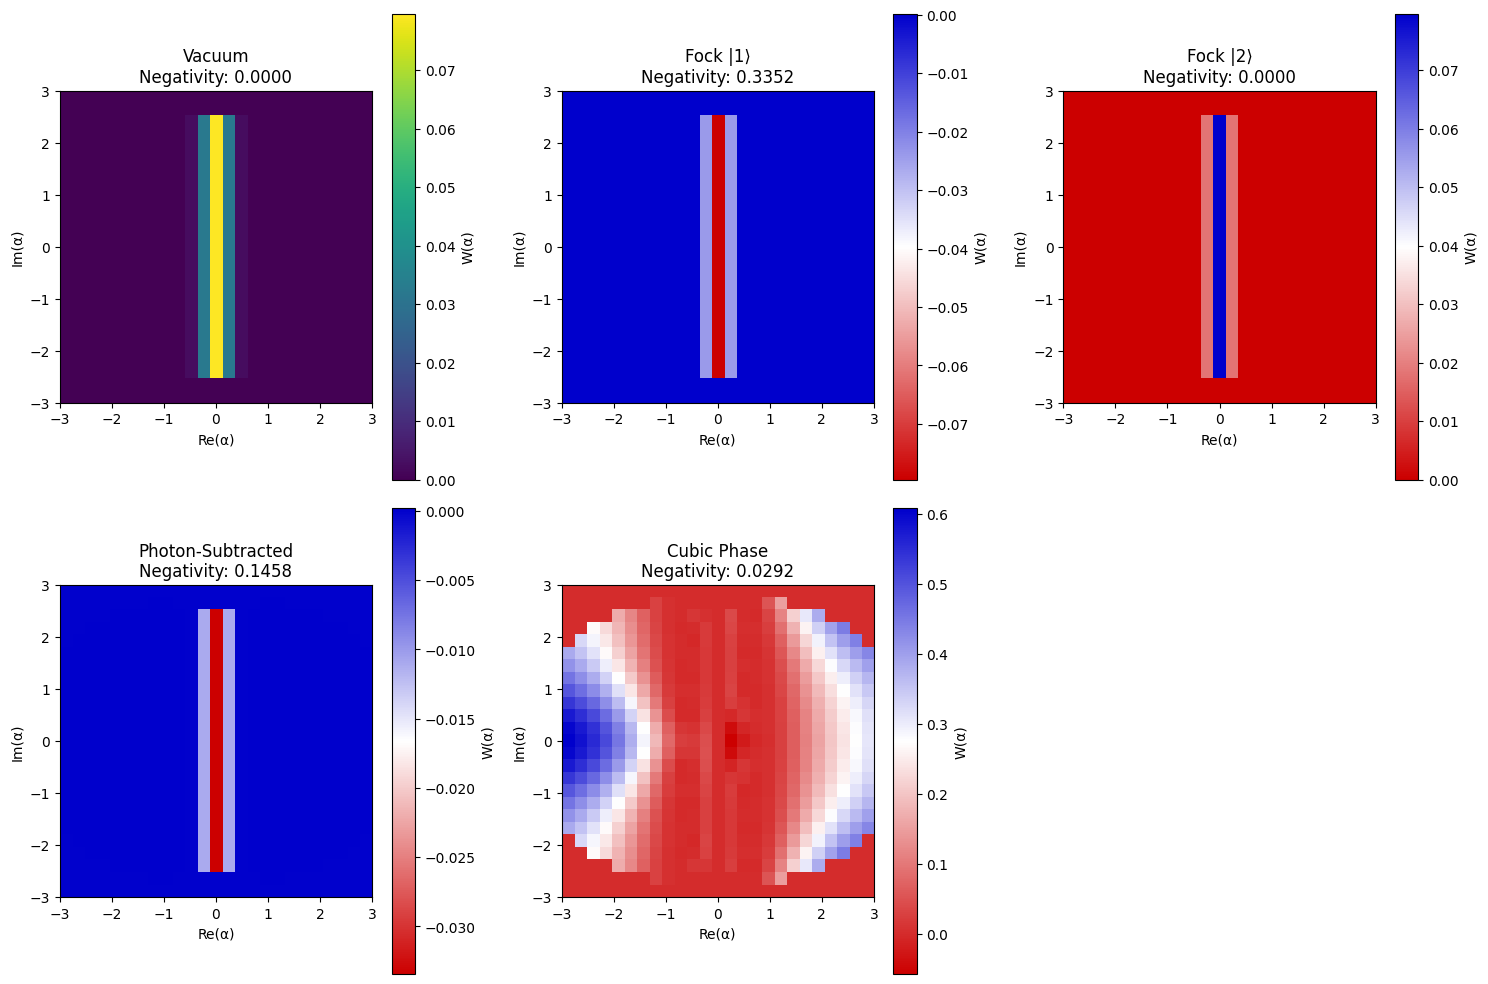

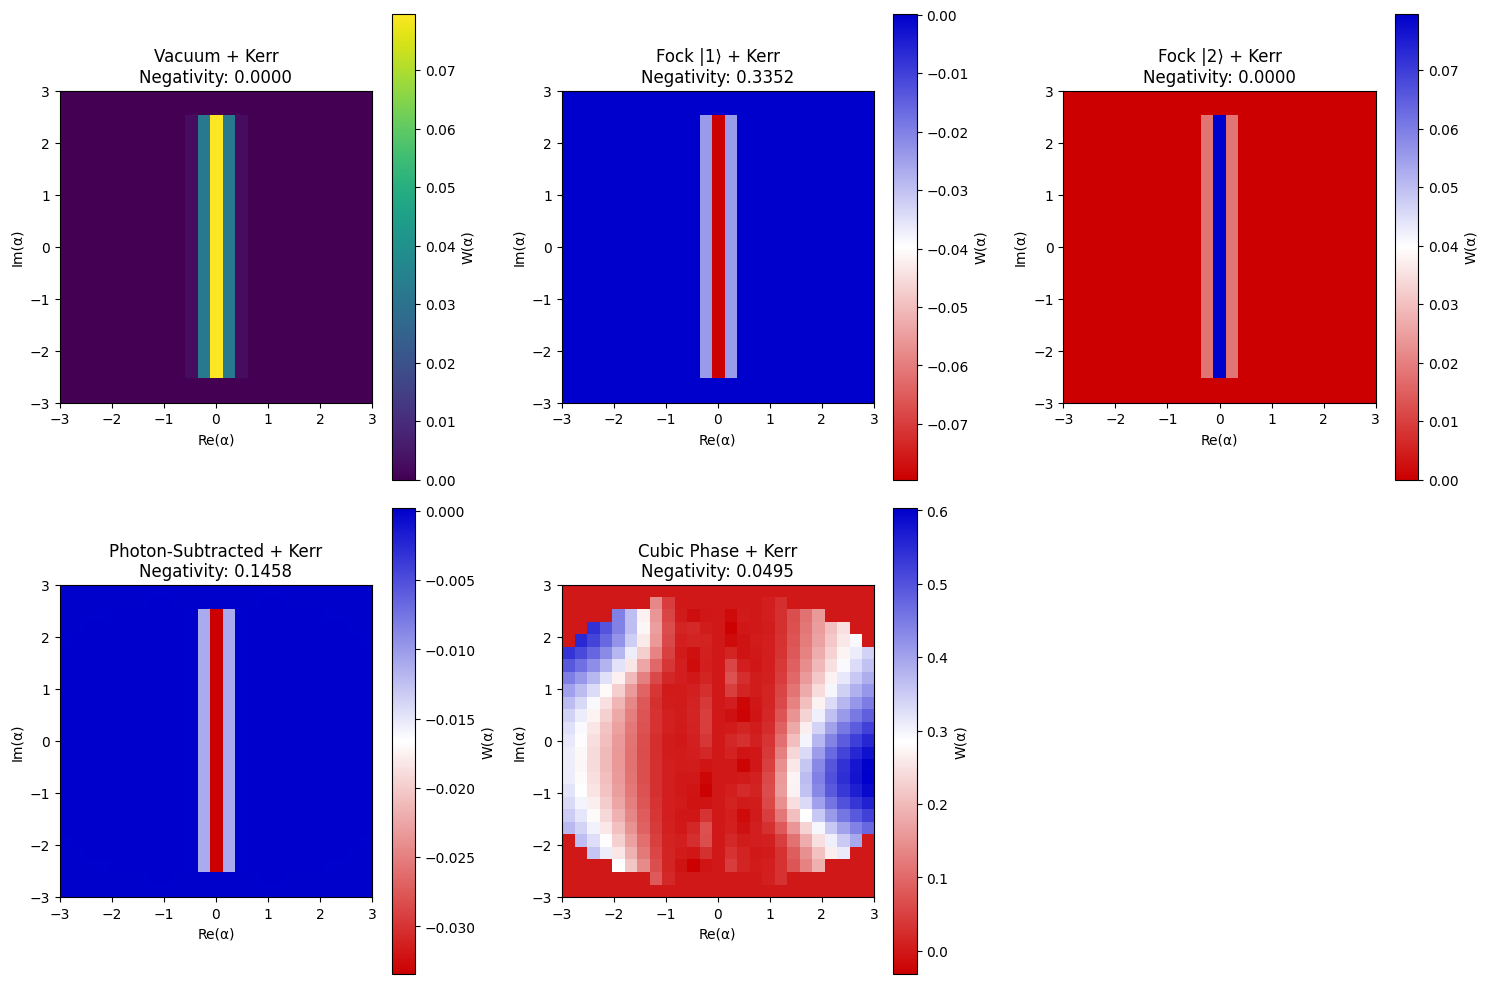

Probe state visualization completed!
Starting Non-Gaussian Quantum Classification Experiments...

Running Basic Classification Experiment
Setting 6 (Full quantum state) - Noise level: 0.0
Setting 4 (Classical features) - Noise level: 0.0
Setting 3 (Regression to classification) - Noise level: 0.0
Setting 5 (Optimal observables) - Noise level: 0.0


<ipython-input-25-475ff9ab8e74>:201: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coef, p_value = pearsonr(negativity_volumes, correct_predictions)


Setting 6 (Full quantum state) - Noise level: 0.1
Setting 4 (Classical features) - Noise level: 0.1
Setting 3 (Regression to classification) - Noise level: 0.1
Setting 5 (Optimal observables) - Noise level: 0.1


<ipython-input-25-475ff9ab8e74>:201: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coef, p_value = pearsonr(negativity_volumes, correct_predictions)


Setting 6 (Full quantum state) - Noise level: 0.2
Setting 4 (Classical features) - Noise level: 0.2
Setting 3 (Regression to classification) - Noise level: 0.2
Setting 5 (Optimal observables) - Noise level: 0.2


<ipython-input-25-475ff9ab8e74>:201: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coef, p_value = pearsonr(negativity_volumes, correct_predictions)


Basic experiment completed!

Running Wigner Negativity Analysis
Starting Wigner negativity analysis...
Analyzing fock...
Analyzing fock + Kerr...
Analyzing photon_subtracted...
Analyzing photon_subtracted + Kerr...
Analyzing cubic_phase...
Analyzing cubic_phase + Kerr...
Running classification for fock probe...
Running classification for photon_subtracted probe...
Running classification for cubic_phase probe...


TypeError: cannot unpack non-iterable NoneType object

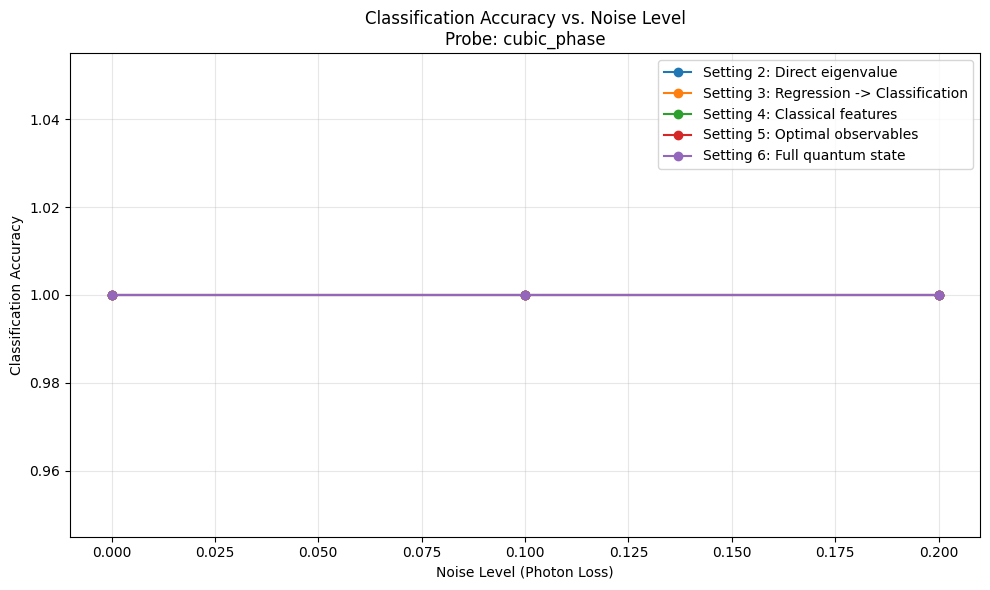

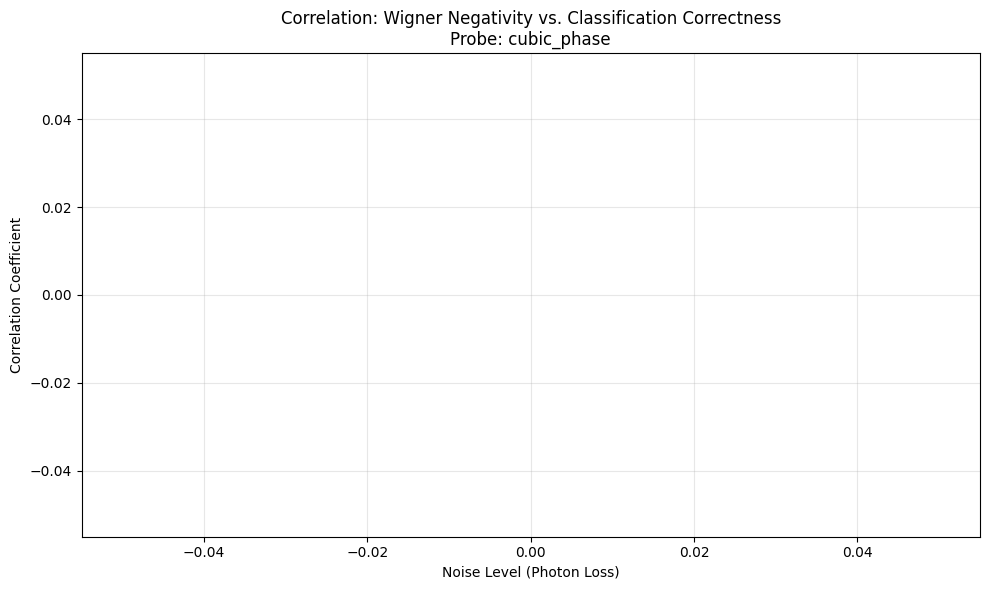

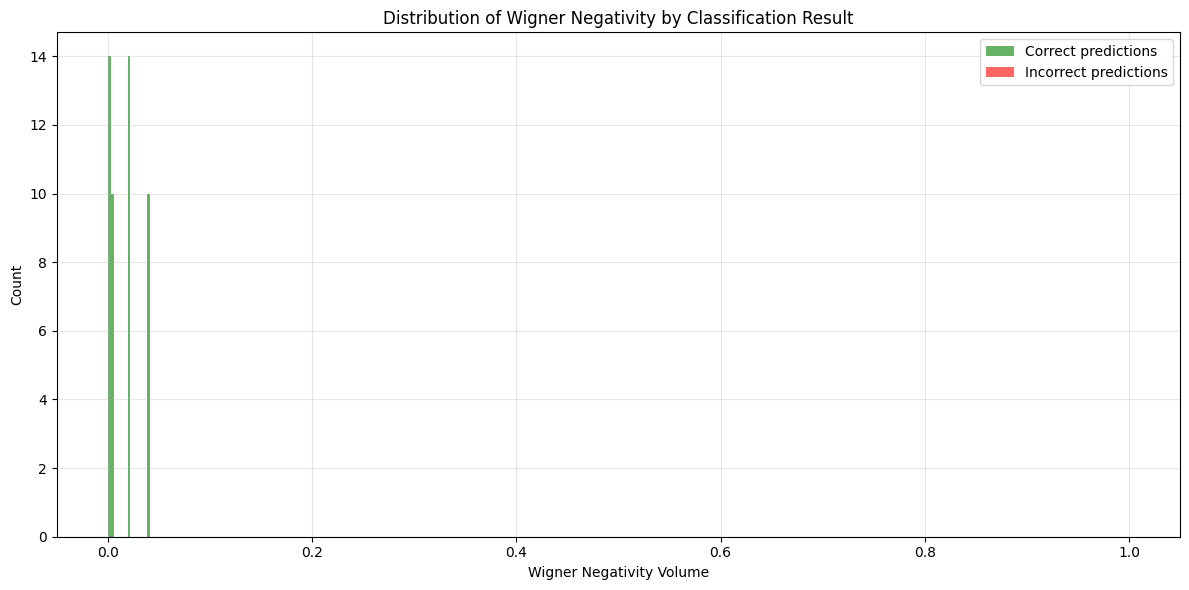

In [ ]:
# @title Main Execution Block
"""
Run Non-Gaussian Quantum Classification Experiments

This script runs a complete set of experiments to compare classical and quantum
learning approaches with a focus on Wigner negativity as a quantum resource.
"""

import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
# Note: We're not importing from quantum_classification as those functions
# are already defined in your Colab environment

# Create output directory for results
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

def save_figure(fig, filename):
    """Save figure to the output directory"""
    full_path = os.path.join(output_dir, filename)
    fig.savefig(full_path, dpi=300, bbox_inches='tight')
    print(f"Saved figure to {full_path}")

def main():
    """Run all experiments"""
    print("Starting Non-Gaussian Quantum Classification Experiments...")
    start_time = time.time()

    # Choose which experiments to run
    run_basic = True
    run_wigner = True
    run_noise = True
    run_confidence = True

    # 1. Basic experiment with one probe type and different noise levels
    if run_basic:
        print("\n" + "="*50)
        print("Running Basic Classification Experiment")
        print("="*50)

        experiment_config = {
            'alpha_list': [0.5, 1.0, 1.5, 2.0],
            'n_samples_per_class': 40,
            'probe_type': 'cubic_phase',
            'chi_val': 0.2,
            'dimension': 8,
            'noise_levels': [0.0, 0.1, 0.2]
        }

        basic_results = run_classification_experiment(experiment_config)

        # Save the summary to CSV
        for noise_level in experiment_config['noise_levels']:
            settings = ['setting2', 'setting3', 'setting4', 'setting5', 'setting6']
            labels = ['Direct eigenvalue', 'Regression -> Class', 'Classical features',
                    'Optimal observables', 'Full quantum state']

            accuracies = [basic_results['accuracies'][noise_level][f'{setting}_accuracy']
                        for setting in settings]

            summary_data = {
                'Setting': labels,
                'Accuracy': accuracies
            }

            df = pd.DataFrame(summary_data)
            df.to_csv(os.path.join(output_dir, f'basic_results_noise_{noise_level}.csv'), index=False)

        print(f"Basic experiment completed!")

    # 2. Wigner negativity analysis with different probe types
    if run_wigner:
        print("\n" + "="*50)
        print("Running Wigner Negativity Analysis")
        print("="*50)

        # Run the analysis
        wigner_results, classification_results, _ = run_wigner_analysis()

        # Visualize the results separately
        _, _, summary_df = visualize_wigner_results(wigner_results, classification_results)

        # Save summary to CSV
        summary_df.to_csv(os.path.join(output_dir, 'wigner_negativity_summary.csv'), index=False)

        print(f"Wigner negativity analysis completed!")

    # 3. Noise robustness experiment
    if run_noise:
        print("\n" + "="*50)
        print("Running Noise Robustness Experiment")
        print("="*50)

        noise_summary = run_noise_robustness_experiment()

        # Save summary to CSV
        noise_summary.to_csv(os.path.join(output_dir, 'noise_robustness.csv'), index=False)

        print(f"Noise robustness experiment completed!")

    # 4. Classification confidence analysis
    if run_confidence:
        print("\n" + "="*50)
        print("Running Classification Confidence Analysis")
        print("="*50)

        confidence_results = visualize_classification_confidence()

        # Save summary to CSV
        confidence_results['summary'].to_csv(os.path.join(output_dir, 'confidence_summary.csv'), index=False)

        print(f"Classification confidence analysis completed!")

    # Calculate total execution time
    end_time = time.time()
    total_time = end_time - start_time
    hours, remainder = divmod(total_time, 3600)
    minutes, seconds = divmod(remainder, 60)

    print("\n" + "="*50)
    print(f"All experiments completed successfully!")
    print(f"Total execution time: {int(hours)}h {int(minutes)}m {seconds:.2f}s")
    print(f"Results saved to {output_dir} directory")
    print("="*50)

def visualize_probe_states():
    """
    Create a visualization of different non-Gaussian probe states
    and their Wigner functions.
    """
    print("Creating probe state visualization...")

    # Define probe types and their parameters
    probes = {
        'Vacuum': {'type': 'vacuum', 'params': {}},
        'Fock |1⟩': {'type': 'fock', 'params': {'n': 1}},
        'Fock |2⟩': {'type': 'fock', 'params': {'n': 2}},
        'Photon-Subtracted': {'type': 'photon_subtracted', 'params': {'squeezing_r': 0.5}},
        'Cubic Phase': {'type': 'cubic_phase', 'params': {'strength': 0.05}}
    }

    # Prepare states
    states = {}
    for name, config in probes.items():
        if config['type'] == 'vacuum':
            states[name] = prepare_vacuum_state()
        else:
            states[name] = prepare_non_gaussian_probe(config['type'], config['params'])

    # Visualize all states
    plt.figure(figsize=(15, 10))

    for i, (name, state) in enumerate(states.items()):
        # Analyze negativity
        neg_results = analyze_wigner_negativity(state)
        negativity = neg_results['negativity_volume']

        # Plot Wigner function
        plt.subplot(2, 3, i+1)
        W_values = neg_results['wigner_function']
        q_vals = neg_results['q_vals']
        p_vals = neg_results['p_vals']

        vmin = np.min(W_values)
        vmax = np.max(W_values)

        if vmin < 0:
            colors = [(0.8, 0, 0), (1, 1, 1), (0, 0, 0.8)]  # red -> white -> blue
            cmap = LinearSegmentedColormap.from_list('custom_diverging', colors, N=256)
            plt.imshow(W_values, extent=[q_vals[0], q_vals[-1], p_vals[0], p_vals[-1]],
                      origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            plt.imshow(W_values, extent=[q_vals[0], q_vals[-1], p_vals[0], p_vals[-1]],
                      origin='lower', cmap='viridis')

        plt.colorbar(label='W(α)')
        plt.xlabel('Re(α)')
        plt.ylabel('Im(α)')
        plt.title(f"{name}\nNegativity: {negativity:.4f}")

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'probe_states.png'), dpi=300)
    plt.show()

    # Create comparison after Kerr application
    chi_val = 0.2
    states_with_kerr = {}

    for name, state in states.items():
        states_with_kerr[f"{name} + Kerr"] = apply_kerr_channel(state, chi_val)

    # Visualize states with Kerr
    plt.figure(figsize=(15, 10))

    for i, (name, state) in enumerate(states_with_kerr.items()):
        # Analyze negativity
        neg_results = analyze_wigner_negativity(state)
        negativity = neg_results['negativity_volume']

        # Plot Wigner function
        plt.subplot(2, 3, i+1)
        W_values = neg_results['wigner_function']
        q_vals = neg_results['q_vals']
        p_vals = neg_results['p_vals']

        vmin = np.min(W_values)
        vmax = np.max(W_values)

        if vmin < 0:
            colors = [(0.8, 0, 0), (1, 1, 1), (0, 0, 0.8)]  # red -> white -> blue
            cmap = LinearSegmentedColormap.from_list('custom_diverging', colors, N=256)
            plt.imshow(W_values, extent=[q_vals[0], q_vals[-1], p_vals[0], p_vals[-1]],
                      origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            plt.imshow(W_values, extent=[q_vals[0], q_vals[-1], p_vals[0], p_vals[-1]],
                      origin='lower', cmap='viridis')

        plt.colorbar(label='W(α)')
        plt.xlabel('Re(α)')
        plt.ylabel('Im(α)')
        plt.title(f"{name}\nNegativity: {negativity:.4f}")

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'probe_states_with_kerr.png'), dpi=300)
    plt.show()

    print("Probe state visualization completed!")

# Execute directly
# Optionally visualize the probe states first
visualize_probe_states()

# Run all experiments
main()